<a href="https://colab.research.google.com/github/achraf-halla/ADME/blob/Solubility-Property/Solubility_AqSolDB_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install PyTDC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.2/154.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of s3fs to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.1/315.1 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from tdc.single_pred import ADME
import pandas as pd

In [3]:
dataset =  ADME(name="Solubility_AqSolDB")


Downloading...
100%|██████████| 853k/853k [00:00<00:00, 8.96MiB/s]
Loading...
Done!


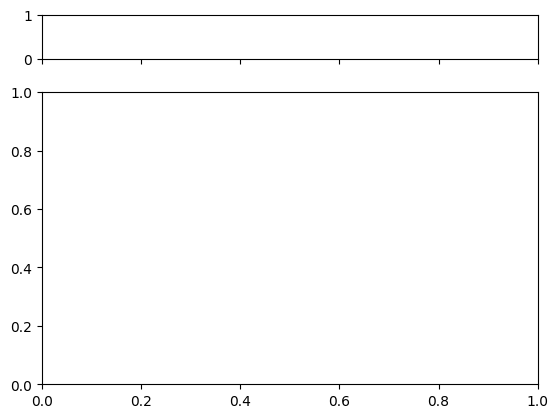

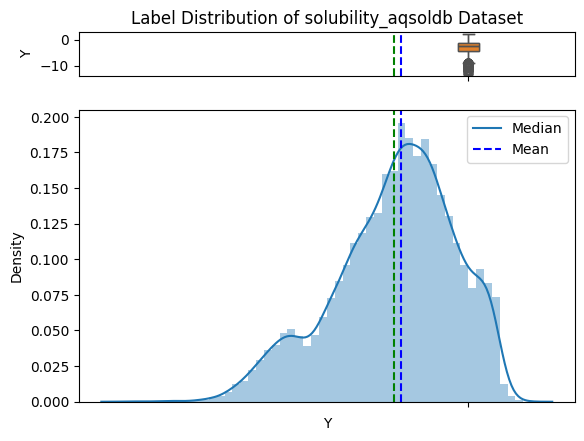

In [4]:
dataset.label_distribution()

In [5]:
split = dataset.get_split (method = "scaffold")

100%|██████████| 9982/9982 [00:03<00:00, 2734.98it/s]


In [47]:
split["train"].head()

,Drug_ID,Drug,Y
0,4-chlorobenzaldehyde,O=Cc1ccc(Cl)cc1,-2.177078
1,vinyltoluene,C=Cc1cccc(C)c1,-3.123150
2,4-(dimethylamino)benzaldehyde,CN(C)c1ccc(C=O)cc1,-2.282769
3,2-methyl-1-phenylpropan-2-yl acetate,CC(=O)OC(C)(C)Cc1ccccc1,-2.394650
4,5-methoxy-1-[4-(trifluoromethyl)phenyl]pentan-...,COCCCCC(=O)c1ccc(C(F)(F)F)cc1,-3.544060


In [49]:
from rdkit import Chem
from rdkit.Chem import Descriptors
m = split["train"].iloc[0]
print(m)
mol = Chem.MolFromSmiles(m["Drug"])
def mol_features(mol):
    features = [
         Descriptors.MolWt(mol),
         Descriptors.MolLogP(mol),
         Descriptors.TPSA(mol),
         Descriptors.NumHDonors(mol),
         Descriptors.NumHAcceptors(mol),
         Descriptors.NumRotatableBonds(mol),
         Descriptors.NumAromaticRings(mol),
         Descriptors.MolMR(mol),
         Descriptors.FractionCSP3(mol),
         Chem.GetFormalCharge(mol)
    ]
    return features


Drug_ID    4-chlorobenzaldehyde
Drug            O=Cc1ccc(Cl)cc1
Y                     -2.177078
Name: 0, dtype: object


In [51]:
mol_features(mol)

[140.569, 2.1525, 17.07, 0, 1, 1, 1, 36.839500000000015, 0.0, 0]

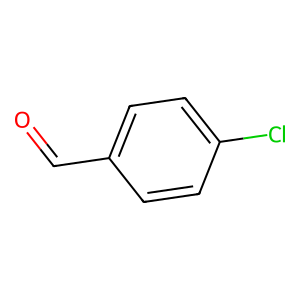

In [52]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

In [53]:
def atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge() ,
        int(atom.GetHybridization()),
        atom.GetIsAromatic()
    ]

In [54]:
for atom in mol.GetAtoms():
  print(atom.GetSymbol())
  print(atom_features(atom))

O
[8, 1, 0, 3, False]
C
[6, 2, 0, 3, False]
C
[6, 3, 0, 3, True]
C
[6, 2, 0, 3, True]
C
[6, 2, 0, 3, True]
C
[6, 3, 0, 3, True]
Cl
[17, 1, 0, 4, False]
C
[6, 2, 0, 3, True]
C
[6, 2, 0, 3, True]


In [55]:
for bond in mol.GetBonds():
    print(bond_features(bond))

[2, True, False]
[1, True, False]
[1, True, True]
[1, True, True]
[1, True, True]
[1, False, False]
[1, True, True]
[1, True, True]
[1, True, True]


In [56]:
pip install  torch_geometric

In [59]:
from torch_geometric.data import Data
import torch

def mol_to_graph(smiles, label):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    x = [atom_features(atom) for atom in mol.GetAtoms()]
    x = torch.tensor(x, dtype=torch.float)

    edge_index = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))


    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    mol_feats = mol_features(mol)
    mol_feats = torch.tensor(mol_features(mol), dtype=torch.float).unsqueeze(0)
    y = torch.tensor([label], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y, mol_feats=mol_feats)

In [61]:
g = mol_to_graph(m['Drug'], m['Y'])

In [62]:
print(f"The number of atoms is {g.num_nodes}  / The number of node features is {g.num_features}")

The number of atoms is 9  / The number of node features is 5


In [63]:
train_graphs = []
for _, row in split["train"].iterrows():
    g = mol_to_graph(row['Drug'], row['Y'])
    if g:
        train_graphs.append(g)

In [64]:
val_graphs = []
for _, row in split["valid"].iterrows():
    g = mol_to_graph(row['Drug'], row['Y'])
    if g:
        val_graphs.append(g)

In [65]:
test_graphs = []
for _, row in split["test"].iterrows():
    g = mol_to_graph(row['Drug'], row['Y'])
    if g:
        test_graphs.append(g)

In [66]:
from torch.utils.data import Dataset

class MoleculeDataset(Dataset):
    def __init__(self, graph_list):
        self.graphs = graph_list

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [67]:
train_dataset = MoleculeDataset(train_graphs)
val_dataset = MoleculeDataset(val_graphs)
test_dataset = MoleculeDataset(test_graphs)


In [68]:
train_dataset.graphs[0]

Data(x=[9, 5], edge_index=[2, 18], y=[1], mol_feats=[1, 10])

In [69]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [70]:
next(iter(train_loader))

DataBatch(x=[462, 5], edge_index=[2, 924], y=[32], mol_feats=[32, 10], batch=[462], ptr=[33])

In [71]:
len(train_graphs)

6987

In [72]:
mol_feats_all = []
atom_feats_all = []

In [73]:
for batch in train_dataset:
    mol_feats_all.append(batch.mol_feats)
    atom_feats_all.append(batch.x)


In [74]:
len(mol_feats_all)

6987

In [75]:
mol_feats_all = torch.cat(mol_feats_all, dim=0)
atom_feats_all = torch.cat(atom_feats_all, dim=0)

In [76]:
def compute_stats(tensor, name=""):
    print(f"{name} stats:")
    print(f"  Mean: {tensor.mean(dim=0)}")
    print(f"  Std: {tensor.std(dim=0)}")
    print(f"  Min: {tensor.min(dim=0).values}")
    print(f"  Max: {tensor.max(dim=0).values}")

compute_stats(mol_feats_all, "Mol Features")
compute_stats(atom_feats_all, "Atom Features")


Mol Features stats:
  Mean: tensor([ 2.4673e+02,  1.7327e+00,  5.9953e+01,  1.0708e+00,  3.2356e+00,
         4.3725e+00,  8.1079e-01,  6.1112e+01,  4.6522e-01, -7.8718e-03])
  Std: tensor([167.0140,   3.5075,  57.5002,   1.4067,   3.0044,   6.0643,   1.1273,
         43.5647,   0.3568,   0.5316])
  Min: tensor([  9.0120, -40.8732,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000, -30.0000])
  Max: tensor([2.9680e+03, 6.8541e+01, 9.6600e+02, 2.4000e+01, 4.0000e+01, 1.4100e+02,
        1.2000e+01, 8.5065e+02, 1.0000e+00, 3.0000e+00])
Atom Features stats:
  Mean: tensor([ 7.1814e+00,  1.9795e+00, -4.9490e-04,  3.4141e+00,  2.9113e-01])
  Std: tensor([4.0786, 0.8263, 0.2441, 0.5506, 0.4543])
  Min: tensor([ 1.,  0., -2.,  1.,  0.])
  Max: tensor([83.,  6.,  5.,  7.,  1.])


In [77]:
print(batch.edge_index.shape)

torch.Size([2, 66])


In [78]:
from torch_geometric.nn import GATv2Conv
import torch.nn as nn
from torch_geometric.nn import global_mean_pool


class GATNet(nn.Module):
    def __init__(self, num_node_features, num_mol_features, hidden_dim=256, heads=4):
        super().__init__()

        self.conv1 = GATv2Conv(num_node_features, hidden_dim, heads=heads)
        # self.conv2 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=heads)
        self.conv3 = GATv2Conv(hidden_dim * heads, hidden_dim, heads=1)

        self.mol_mlp = nn.Sequential(
            nn.Linear(num_mol_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        self.lin = nn.Linear(hidden_dim * 2, 1)

    def forward(self, batch):
        x, edge_index,  batch_idx, mol_feats = batch.x, batch.edge_index,  batch.batch, batch.mol_feats

        x = torch.relu(self.conv1(x, edge_index))
        # x = torch.relu(self.conv2(x, edge_index, edge_attr))
        x = torch.relu(self.conv3(x, edge_index))


        x = global_mean_pool(x, batch_idx)
        mol_feats = self.mol_mlp(mol_feats)

        out = torch.cat([x, mol_feats], dim=1)
        return self.lin(out).squeeze()


In [79]:
model = GATNet(num_node_features=train_dataset[0].x.shape[1],num_mol_features= train_dataset[0].mol_feats.shape[1])


In [80]:
model

GATNet(
  (conv1): GATv2Conv(5, 256, heads=4)
  (conv3): GATv2Conv(1024, 256, heads=1)
  (mol_mlp): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (lin): Linear(in_features=512, out_features=1, bias=True)
)

In [81]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
for epoch in range(50):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch.mol_feats = batch.mol_feats.float()
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} | Loss: {total_loss / len(train_loader):.4f}")

    model.eval()
    val_loss = 0
    with torch.inference_mode():
        for batch in val_loader:
            batch.mol_feats = batch.mol_feats.float()
            out = model(batch)
            val_loss += criterion(out, batch.y.view(-1)).item()

    val_loss /= len(val_loader)
    print(f"Epoch {epoch} | Val Loss: {val_loss:.4f}")


Epoch 0 | Loss: 1.5705
Epoch 0 | Val Loss: 1.5185
Epoch 1 | Loss: 1.4197
Epoch 1 | Val Loss: 1.4834
Epoch 2 | Loss: 1.4003
Epoch 2 | Val Loss: 1.4527
Epoch 3 | Loss: 1.3922
Epoch 3 | Val Loss: 1.5116
Epoch 4 | Loss: 1.3596
Epoch 4 | Val Loss: 1.4143
Epoch 5 | Loss: 1.3441
Epoch 5 | Val Loss: 1.4589
Epoch 6 | Loss: 1.3263
Epoch 6 | Val Loss: 1.4789
Epoch 7 | Loss: 1.3034
Epoch 7 | Val Loss: 1.4311
Epoch 8 | Loss: 1.2911
Epoch 8 | Val Loss: 1.4304
Epoch 9 | Loss: 1.2906
Epoch 9 | Val Loss: 1.4596
Epoch 10 | Loss: 1.2790
Epoch 10 | Val Loss: 1.4236
Epoch 11 | Loss: 1.2573
Epoch 11 | Val Loss: 1.3618
Epoch 12 | Loss: 1.2407
Epoch 12 | Val Loss: 1.3825
Epoch 13 | Loss: 1.2404
Epoch 13 | Val Loss: 1.3819
Epoch 14 | Loss: 1.2302
Epoch 14 | Val Loss: 1.3637
Epoch 15 | Loss: 1.2362
Epoch 15 | Val Loss: 1.3771
Epoch 16 | Loss: 1.2351
Epoch 16 | Val Loss: 1.3751
Epoch 17 | Loss: 1.1956
Epoch 17 | Val Loss: 1.2988
Epoch 18 | Loss: 1.2166
Epoch 18 | Val Loss: 1.3547
Epoch 19 | Loss: 1.2068
Epoch 19

In [82]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [83]:
count_parameters(model)

608769